# Investigate Mapping between Seismic Stations and Boreholes

In [38]:
import geopandas as gpd
import rf
import os
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from shapely import Point
import numpy as np
from joblib import Parallel, delayed

Load RF data

In [2]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])

Make geodataframe with relevant seismic data

In [3]:
stations = []
points = []
tpsbs = []
for tr in stacks:
    stations.append(".".join([tr.stats.network, tr.stats.station]))
    points.append(Point(tr.stats.station_longitude, tr.stats.station_latitude))
    tpsbs.append(tr.stats.delay)
seismics = gpd.GeoDataFrame(data={"stations": stations, "delays": tpsbs, "geometry": points})
seismics.set_index("stations", inplace=True)

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


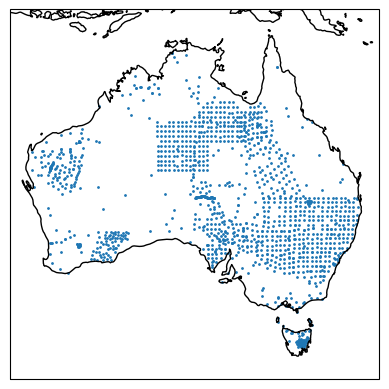

In [4]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=133))
ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
ax.coastlines()

ax.scatter(seismics.geometry.x, seismics.geometry.y, transform=ccrs.PlateCarree(), s=1)

Load boreholedata

In [5]:
dataroot = os.path.join("..", "data", "ABSUC")
boreholes = gpd.read_file(os.path.join(dataroot, "boreholes.geojson"))

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


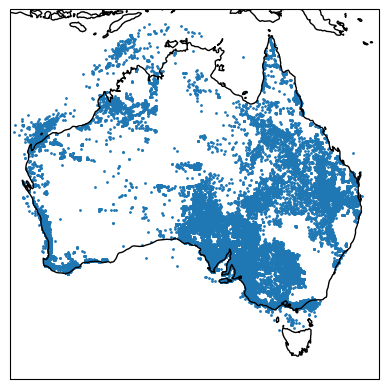

In [6]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=133))
ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
ax.coastlines()

ax.scatter(boreholes.GDA94_LONGITUDE, boreholes.GDA94_LATITUDE, transform=ccrs.PlateCarree(), s=1)

Choose a random station and map polar histogram of borehole counts

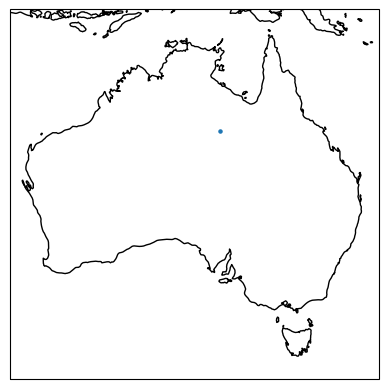

In [7]:
p1 = seismics.geometry[158]
ax = plt.axes(projection=ccrs.Robinson(central_longitude=133))
ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
ax.coastlines()
ax.scatter([p1.x], [p1.y], transform=ccrs.PlateCarree(), s=5)

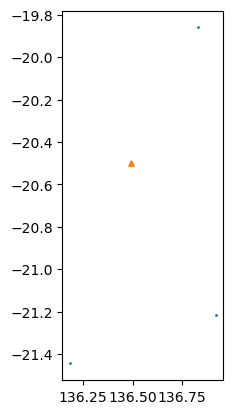

In [8]:
max_dist = 1  # degrees
dists = p1.distance(boreholes.geometry)
dists = dists[dists <= max_dist]
ax = plt.axes()
boreholes.iloc[dists.index].plot(ax=ax, markersize=1)
ax.scatter([p1.x], [p1.y], s=15, marker="^")

In [67]:
geo = Geodesic()  # returns distances in meters
bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T
max_dist = 1  # degrees
max_dist *= 111  # km

# define binning
rbins = np.linspace(0, max_dist, 20)
abins = np.linspace(0, 2 * np.pi, 36)
R, A = np.meshgrid(rbins, abins)


def build_hist(point):
    inv = geo.inverse([point.x, point.y], bh_array)
    inv[:, 0] /= 1000  # m -> km
    dists = inv[inv[:, 0] <= max_dist, 0]
    azs = inv[inv[:, 0] <= max_dist, 1] + 180  # range 0-360
    # calculate histogram
    hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
    return hist


seismics["histograms"] = Parallel(n_jobs=-1)(
    delayed(build_hist)(p1) for p1 in seismics.geometry
)
seismics["borehole_count"] = seismics.histograms.apply(lambda x: int(x.sum()))


def get_closest_borehole_distance(station):
    inv = geo.inverse([station.x, station.y], bh_array)
    dists = inv[:, 0] / 1000  # m -> km
    return dists.min()


seismics["closest_borehole_distance"] = np.array(
    Parallel(n_jobs=-1)(
        delayed(get_closest_borehole_distance)(p) for p in seismics.geometry
    )
)

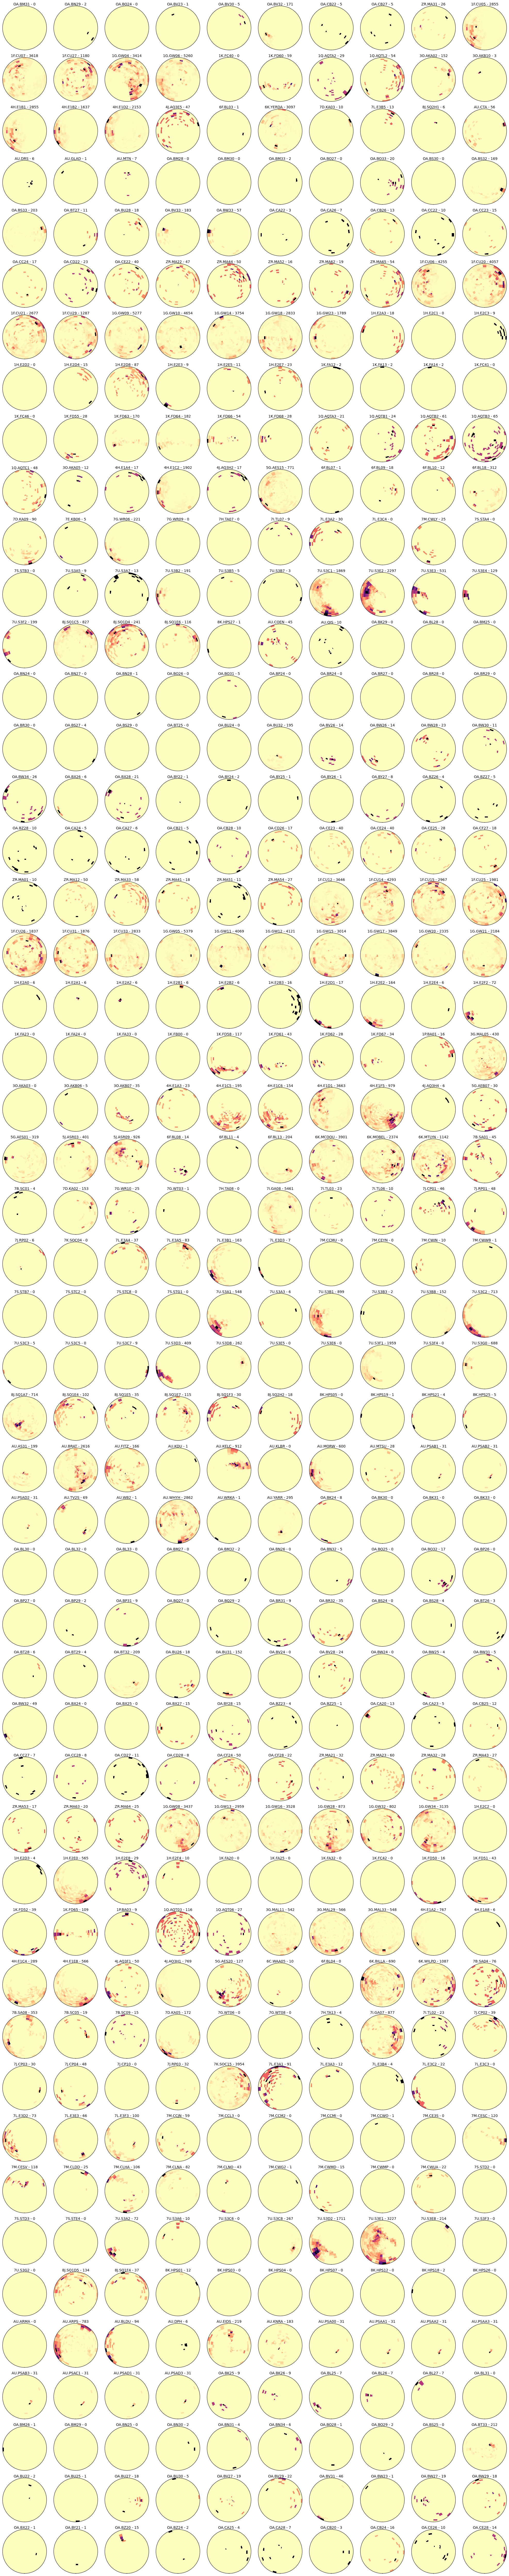

In [33]:
nrows = 50
ncols = 10
row_h = 2  # inches
col_w = 2  # inches
fig, axs = plt.subplots(
    nrows,
    ncols,
    subplot_kw=dict(projection="polar"),
    figsize=(ncols * col_w, nrows * row_h),
    tight_layout=True,
)
for ax, (i, s) in zip(axs.flatten(), seismics.iterrows()):
    # plot
    ax.grid(False)
    ax.pcolormesh(A, R, s.histograms.T, cmap="magma_r")
    ax.text(
        0.5,
        1,
        f"{i} - {int(s.borehole_count)}",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
    )

    # hack to get the axes and image the right way around
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    # ax.set_xticklabels(['180°', '225°', '270°', '315°', '0°', '45°', '90°', '135°'])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

Text(0.5, 1.0, 'Seismic stations with 0 borehole within 1°')

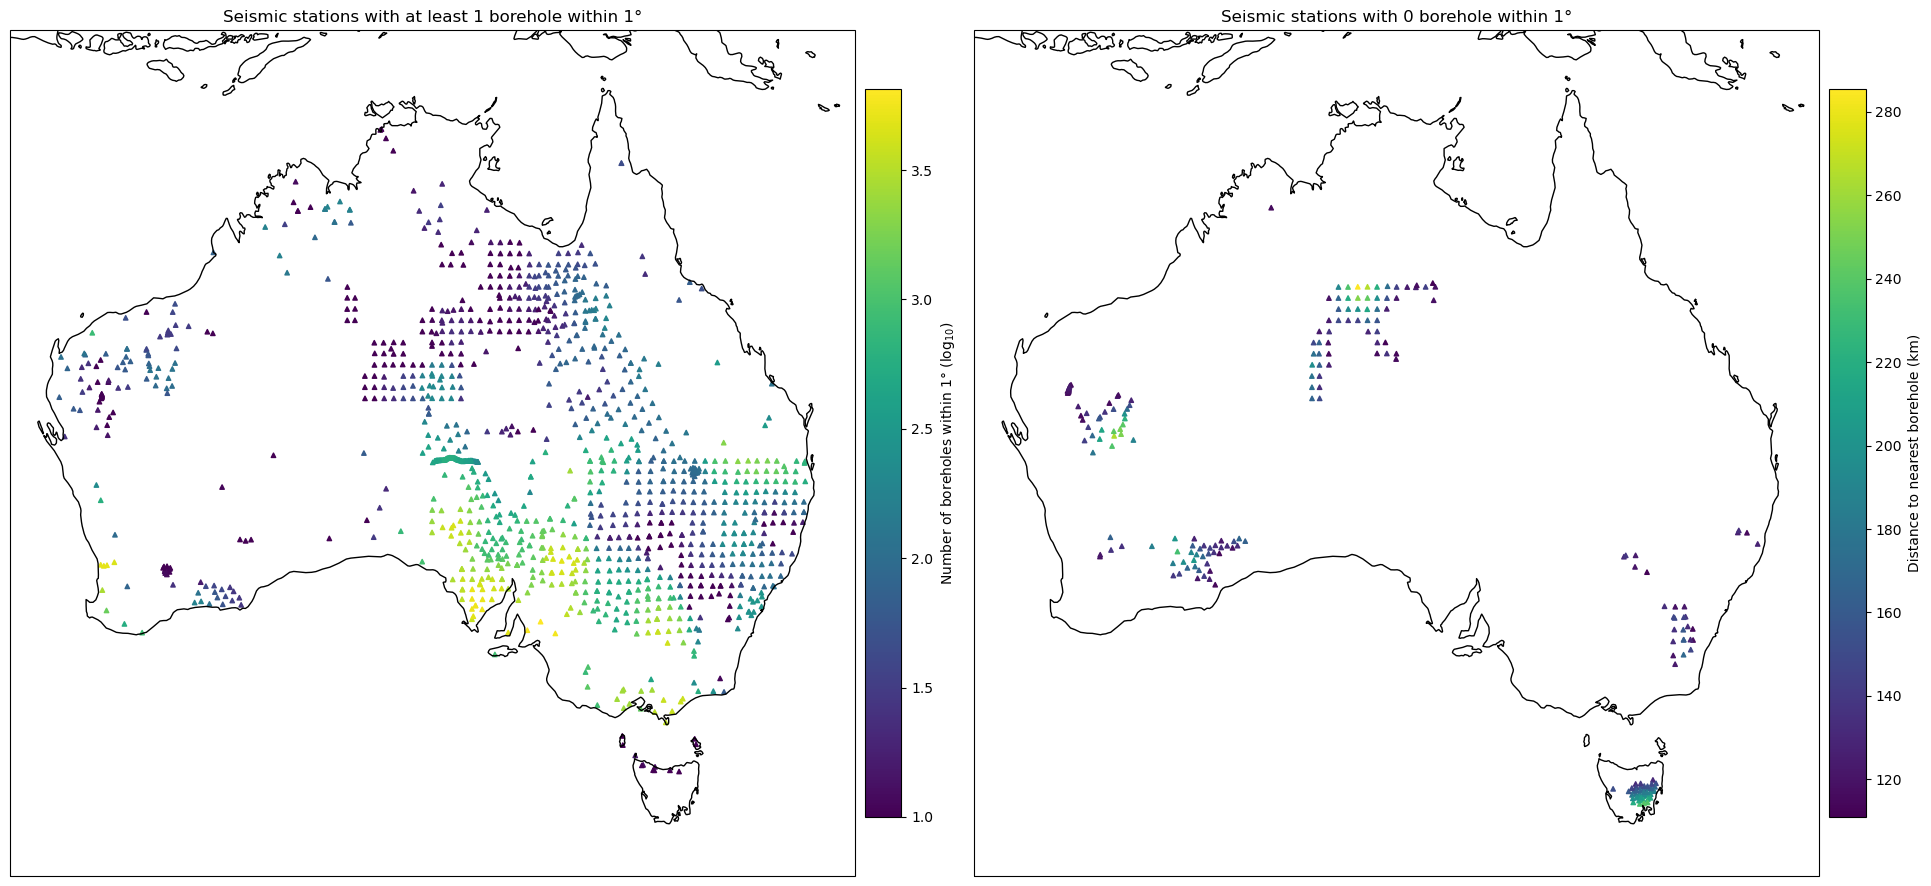

In [86]:
fig, axs = plt.subplots(
    1,
    2,
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=133)),
    figsize=(20, 10),
    tight_layout=True,
)
for ax in axs:
    ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
    ax.coastlines()

ax = axs[0]
vmin = 1
vmax = np.log10(seismics.borehole_count).max()
ax.scatter(
    seismics.geometry.x[seismics.borehole_count > vmin],
    seismics.geometry.y[seismics.borehole_count > vmin],
    c=np.log10(seismics.borehole_count[seismics.borehole_count > vmin]),
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    transform=ccrs.PlateCarree(),
    s=10,
    marker="^",
)
fig.colorbar(
    cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap="viridis"),
    ax=ax,
    label="Number of boreholes within 1° ($\log_{10}$)",
    shrink=0.75,
    pad=0.01,
)
ax.set_title("Seismic stations with at least 1 borehole within 1°")

ax = axs[1]
vmin = max_dist
vmax = seismics.closest_borehole_distance.max()
ax.scatter(
    seismics.geometry.x[seismics.borehole_count == 0],
    seismics.geometry.y[seismics.borehole_count == 0],
    c=seismics.closest_borehole_distance[seismics.borehole_count == 0],
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    transform=ccrs.PlateCarree(),
    s=10,
    marker="^",
)
fig.colorbar(
    cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap="viridis"),
    ax=ax,
    label="Distance to nearest borehole (km)",
    shrink=0.75,
    pad=0.01,
)
ax.set_title("Seismic stations with 0 borehole within 1°")